# House 91912
## Tasks
<ul>
    <li> Work Out Rated Power of Hot Water [x]
    <li> Work Out how long it runs each day [x]
    <li> Calculate how many hours it runs outside of solar hours [ ]
</ul>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

house_id = 91912
df = pd.read_csv('../data/'+str(house_id)+'.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop_duplicates(keep='first', inplace=True)
df['reading_datetime'] = pd.to_datetime(df['reading_datetime'])
df.set_index('reading_datetime', inplace=True)
df.sort_index(inplace=True)
df['circuit_id_monitor'] = df.circuit_id.astype(str) + ' <<' +df.monitors+'>>'

p = df.reset_index()
p = p.pivot(index='reading_datetime', columns='circuit_id_monitor', values=['energy', 'energy_pos', 'energy_neg'])
all_power = p[:]['energy']

# Hot water Circuit id: 70132
load_type = 'pool'
load = all_power.filter(regex=load_type).copy(deep=True)
load.rename(columns={load.columns[0]:'power'}, inplace=True)
print("LOAD: " + load_type)

print('Setup Complete')

LOAD: pool
Setup Complete


### Rated Power Calculation
The reading comes as Wh consumed in a 5 minute period <br>
It needs to be converted to Power in kW to understand the draw of appliance

$ R = E \times \frac{5}{60} \times 1000 $

The appliance is not guaranteed to start neatly at the start of each 5 minute interval.
It cannot be assumed the average rated power is the true rated power as there are significant
lower outliers to the power calculated.

Constraining the power values considered to periods where the appliance is "on" for 90% of the time
gives a better result for rated power.

"on" period is defined as:

$ on = \frac{power}{max(power)} $

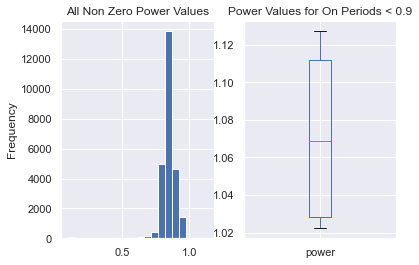

Rated Power: 1.07kW


In [2]:
# Hot water Circuit id: 70132
load_investigation = all_power.filter(regex=load_type).copy(deep=True)
load_investigation.rename(columns={load_investigation.columns[0]:'power'}, inplace=True)
load_investigation = (load_investigation * 12) / 1000
rated_power = load_investigation.power.max()
load_investigation['on_time'] = (load_investigation.power / rated_power)

on = load_investigation.loc[load_investigation.power > 0.1]
fig, ax = plt.subplots(nrows=1, ncols=2)
on.power.plot.hist(title='All Non Zero Power Values', ax=ax[0], bins=20)
period = 0.9
on = load_investigation.loc[load_investigation.on_time > period]
on.power.plot.box(title='Power Values for On Periods < ' + str(period), ax=ax[1])
plt.show()
rated_power = on.power.median()
load_investigation['on_time'] = (load_investigation.power / rated_power) * 5
print('Rated Power: ' + "{:.2f}".format(rated_power) + 'kW')
# load = (load * 1000) / 12


### Duration Calculation

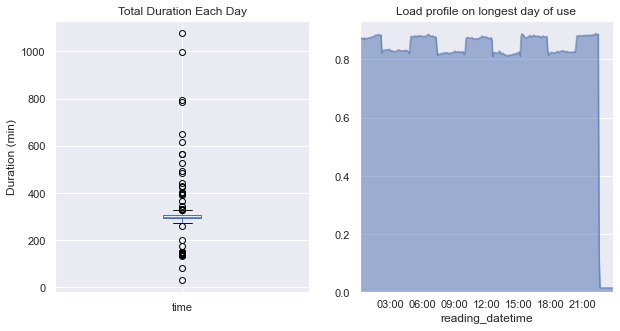

Duration Average: 4.94h


In [3]:
load_24h = load_investigation[['power', 'on_time']].copy(deep=True)
load_24h['time'] = load_24h.on_time
load_24h = load_24h.resample('24h', offset=12).sum()
non_zero_days = load_24h[load_24h.time > 20].time
longest_day = load_24h.time.idxmax()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
load_investigation[str(longest_day.date())].power.clip(lower=0).plot.area(title='Load profile on longest day of use',ax=ax[1], alpha=0.5)
non_zero_days.plot.box(title='Total Duration Each Day', ax=ax[0])
ax[0].set_ylabel('Duration (min)')
plt.show()

print('Duration Average: ' + "{:.2f}".format((non_zero_days.mean() / 60)) + 'h')



In [9]:
p.head()

energy                      \
circuit_id_monitor  77468 <<ac_load_net>> 77469 <<load_pool>>   
reading_datetime                                                
2019-01-01 00:00:00              165.0403              1.2578   
2019-01-01 00:05:00              146.0383              1.2417   
2019-01-01 00:10:00              142.8256              1.2372   
2019-01-01 00:15:00              152.6675              1.2325   
2019-01-01 00:20:00              147.1406              1.2275   

                                                                              \
circuit_id_monitor  77470 <<load_powerpoint>> 77471 <<load_air_conditioner>>   
reading_datetime                                                               
2019-01-01 00:00:00                   43.4014                        41.8097   
2019-01-01 00:05:00                   60.6169                        41.3072   
2019-01-01 00:10:00                   61.1081                        41.0642   
2019-01-01 00:15:00                   71.7158                        41.0153   
2019-01-01 00:20:00                   70.6264                        41.1019   

                                                         energy_pos  \
circuit_id_monitor  77472 <<load_powerpoint>> 77468 <<ac_load_net>>   
reading_datetime                                                      
2019-01-01 00:00:00                    0.0181              165.0403   
2019-01-01 00:05:00                   -0.0039              146.0383   
2019-01-01 00:10:00                   -0.0017              142.8256   
2019-01-01 00:15:00                   -0.0122              152.6675   
2019-01-01 00:20:00                   -0.0069              147.1406   

                                                                   \
circuit_id_monitor  77469 <<load_pool>> 77470 <<load_powerpoint>>   
reading_datetime                                                    
2019-01-01 00:00:00              1.2578                   43.4014   
2019-01-01 00:05:00              1.2417                   60.6169   
2019-01-01 00:10:00              1.2372                   61.1081   
2019-01-01 00:15:00              1.2325                   71.7158   
2019-01-01 00:20:00              1.2275                   70.6264   

                                                                              \
circuit_id_monitor  77471 <<load_air_conditioner>> 77472 <<load_powerpoint>>   
reading_datetime                                                               
2019-01-01 00:00:00                        41.8097                    0.0181   
2019-01-01 00:05:00                        41.3072                    0.0019   
2019-01-01 00:10:00                        41.0642                    0.0011   
2019-01-01 00:15:00                        41.0153                    0.0000   
2019-01-01 00:20:00                        41.1019                    0.0000   

                               energy_neg                      \
circuit_id_monitor  77468 <<ac_load_net>> 77469 <<load_pool>>   
reading_datetime                                                
2019-01-01 00:00:00                   0.0                 0.0   
2019-01-01 00:05:00                   0.0                 0.0   
2019-01-01 00:10:00                   0.0                 0.0   
2019-01-01 00:15:00                   0.0                 0.0   
2019-01-01 00:20:00                   0.0                 0.0   

                                                                              \
circuit_id_monitor  77470 <<load_powerpoint>> 77471 <<load_air_conditioner>>   
reading_datetime                                                               
2019-01-01 00:00:00                       0.0                            0.0   
2019-01-01 00:05:00                       0.0                            0.0   
2019-01-01 00:10:00                       0.0                            0.0   
2019-01-01 00:15:00                       0.0                            0.0   
2019-01-01 00:20:00          

House Usage Total		9931.32kWh
Export total			0.00kWh
PV utilisation total		9931.32kWh
Import total			9931.32kWh
usage total - util total	0.00kWh


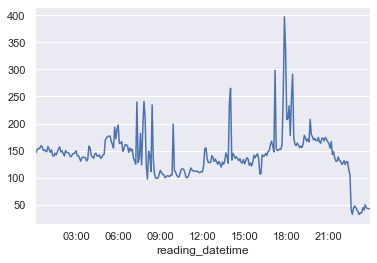

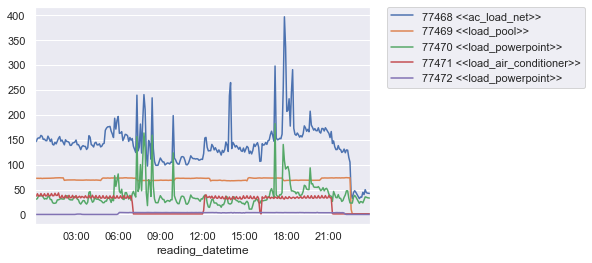

In [11]:
#get load by itself
load = all_power.filter(regex=load_type).copy(deep=True)
load.rename(columns={load.columns[0]:'power'}, inplace=True)

# this is some magic regex, Looks for columns that aren't AC net or PV net
not_ac_pv = p['energy'].filter(regex='^((?!ac_load_net|pv_site_net).)*$').copy(deep=True)
# Sum all the loads that aren't AC net or PV net
not_ac_pv_sum = not_ac_pv.sum(axis=1)
# Calculate excess PV from

#Total Rooftop Generation
# pv_df = p.filter(regex='pv_site_net')['energy'].sum(axis=1)
ac_df = p.filter(regex='ac_load_net')['energy'].sum(axis=1)

# excess_pv_from_parts = ((not_ac_pv_sum - pv_df - load.power) * -1).clip(lower=0)

grid_export = (p.filter(regex='ac_load_net')['energy'].sum(axis=1) * - 1).clip(lower=0)

ac_load_net = p.filter(regex='ac_load_net')['energy']
ac_load_net = ac_load_net.sum(axis=1)
# removes the PV component to expose
house_consumption = ac_load_net
house_consumption_diff = house_consumption.diff()
load_diff = load.power.diff()
house_spikes = (house_consumption_diff.abs() > house_consumption_diff.std())
load_spikes = (load_diff.abs() > load_diff.std())
aligned = load_spikes & house_spikes

if aligned.sum() / load_spikes.sum() > 0.05:
    house_consumption = house_consumption
else:
    house_consumption = house_consumption + load.power

house_consumption_without_load = house_consumption - load.power

grid_import = ac_load_net.clip(lower=0)

pv_utilisation = pd.concat([house_consumption], axis=1).min(axis=1)

house_consumption_total = house_consumption.sum() / 1000
# pv_gen_total = pv_df.sum() / 1000
grid_import_total = grid_import.sum() / 1000
grid_export_total = grid_export.sum() / 1000
pv_utilisation_total = pv_utilisation.sum() /1000

# export = pv_df - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
# print('pv_df - pv_utilisation\t\t' + "{:.2f}".format(export_total) + "kWh")
print("PV utilisation total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")

print('usage total - util total\t'+"{:.2f}".format(house_consumption_total - pv_utilisation_total) + "kWh")


# pv_df[str(longest_day.date())].plot(label='PV Generation')
house_consumption[str(longest_day.date())].plot(label='House Consumption')
# pv_utilisation[str(longest_day.date())].clip(0).plot.area(alpha=0.5, label='PV Self-Consumed')
# export[str(longest_day.date())].plot(label='PV exported')
# grid_export[str(longest_day.date())].plot(label='Exported')
# grid_import[str(longest_day.date())].plot(label='Imported')
# load.power[str(longest_day.date())].plot(label='Load')
all_power[str(longest_day.date())].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()